# Определение стоимости автомобилей

***ЗАДАЧА***

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания
- скорость предсказания
- время обучения


***ПЛАН РАБОТЫ***

- Загрузить и подготовить данные
- Обучить и протестировать разные модели. Для каждой попробовать различные гиперпараметры
- Проанализировать скорость работы и качество моделей

Примечания:

- Для оценки качества моделей необходимо применить метрику RMSE
- Освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга

***ОПИСАНИЕ ДАННЫХ***

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

## Подготовка данных

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
# !pip install catboost
from catboost import CatBoostRegressor
# !pip install lightgbm
from lightgbm import LGBMRegressor

import timeit

pd.set_option('display.max_colwidth', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Изучение данных и первичная предобработка

Загрузим и сохраним данные в переменную

In [2]:
try:
    car_df = pd.read_csv('/datasets/autos.csv')
except:
    car_df = pd.read_csv(r'C:\Users\Admiral\Desktop\учеба\практикум\Проекты\Datasets\10_autos.csv')

Для дальнейшего сравнения сохраним количество признаков в отдельную переменную

In [3]:
LEN_DF = car_df.shape[0]

Выведем первые и последнии 5 объектов

In [4]:
display(car_df.head())
display(car_df.tail())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Для дальнейшего удобства приведем наименования столбцов к нижнему регистру и разделим слова нижним подчеркиванием. Выведем наименования колонок для проверки

In [5]:
car_df.rename((lambda x: '_'.join(re.findall('[A-Z][^A-Z]*', x)).lower()), axis='columns', inplace=True)
display(car_df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Выведем краткую информацию по столбцам

In [6]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Выведем количество пропусков в каждом столбце в процентном соотношении от общего количества наблюдений. Для этого подготовим отдельную функцию и воспользуемся ей

In [7]:
def percent_nan_columns(df, inf):
    print('\033[1m' + f'Количество пропусков по столбцам{inf}, %:' + '\033[0m')
    display(df.isna().sum().apply(lambda x: round((x * 100 / df.shape[0]), 1)))

In [8]:
percent_nan_columns(car_df, '')

Количество пропусков по столбцам, %:


date_crawled           0.0
price                  0.0
vehicle_type          10.6
registration_year      0.0
gearbox                5.6
power                  0.0
model                  5.6
kilometer              0.0
registration_month     0.0
fuel_type              9.3
brand                  0.0
not_repaired          20.1
date_created           0.0
number_of_pictures     0.0
postal_code            0.0
last_seen              0.0
dtype: float64

Сделаем первые выводы:
- Данные имеют 354369 объектов с разделением на 16 признаков.
- Столбцы "date_crawled", "registration_year", "registration_month", "date_created" и "last_seen" несут временную информацию о дате скачивания анкеты из базы, годе регистрации автомобиля, месяце регистрации автомобиля, дате создания анкеты и дате последней активности пользователя соответственно. Не думаю, что данные столбцы, кроме года и месяца регистрации автомобиля, в дальнейшем понадобятся нам в задаче регрессии (предсказание стоимости автомобиля), возможно позже избавимся от них.
- Столбец "price" является целевым признаком (стоимость автомобиля в евро). Пропуски отсутствуют, тип данных int64. Возможно нам удастся сократить использование памяти за счет изменения типа данных, но для этого необходимо знать разброс значений в данном столбце.
- Столбецы "vehicle_type", "gearbox","model" и "fuel_type" несут информацию о типе кузова, типе коробки передач, модели автомобиля и типе топлива, имеют 10.6%, 5.6%, 5.6% и 9.3% пропусков соответственно, тип данных - object. Необходимо обработать пропуски, а также перевести тип данных стобцов из категориального в численный методом использования кодировщика OneHotEncoder.
- Столбец "brand" несет информацию о бренде автомобиля, пропуски отсутствуют, тип данных - object. Так же необходимо закодировать данный столбец для замены признака на численный тип.
- Столбцы "power" и "kilometer" несут информацию о мощности двигателя в лошадиных силах и о пробеге автомобиля в километрах. Пропуски отсутствуют, тип данных подходящий.
- Столбец "not_repaired" несет информацию о том, была ли машина в ремонте или нет. В данном столбце самое большое количество пропусков - 20.1%. Кроме того тип данных не подходящий для обучения модели - object. Необходимо обработать пропуски, а также перевести тип данных стобца из категориального в численный методом использования кодировщика OneHotEncoder.
- В столбцах "number_of_pictures" и "postal_code" отображена информация о количестве фотографий автомобиля в анкете и о почтовом индексе владельца анкеты. Пропуски отсутствуют, но есть подозрение о сплошных нулях в столбце "number_of_pictures", необходимо это проверить. В любом случае данный столбец врятли понадобится нам в обучении модели, так как информация о количетве фотографий не имеет ценности для предсказания стоимости автомобиля.

Изучим краткую статистическую информацию по числовым признакам

In [9]:
display(car_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


У целевого признака имеются нулевые значения, это плохо, мы не сможем по таким объектам обучить модель, придется избавится от этих строк. Вероятно, люди забесплатно отдают машины, чтобы не платить налоги за утилизацию. Для начала узнаем количество потерянных данных

In [10]:
print(f'Количество строк с нулевыми значениями у целевого признака: {car_df.query("price == 0").shape[0]},',\
      f'что составляет {car_df.query("price == 0").shape[0]/ car_df.shape[0]:.2%}')

Количество строк с нулевыми значениями у целевого признака: 10772, что составляет 3.04%


Количество невелико и толку от таких наблюдений нет. Удалим эти строки

In [11]:
car_df = car_df.query('price != 0').reset_index(drop=True)

Подготовим функцию для вывода совместного графика гистограммы и ящика с усами

In [12]:
def hist_boxplot(col, titl, xlabl):
    sns.set(style='darkgrid')
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 7))

    sns.boxplot(col, ax=ax_box, color='orange')
    sns.distplot(col, ax=ax_hist, color='orange')

    ax_box.set(xlabel='')
    ax_hist.set(xlabel=xlabl)
    plt.title(f'График расределения {titl}', pad=110, fontsize=18)
    plt.show()

Изучим график распределения целевого признака

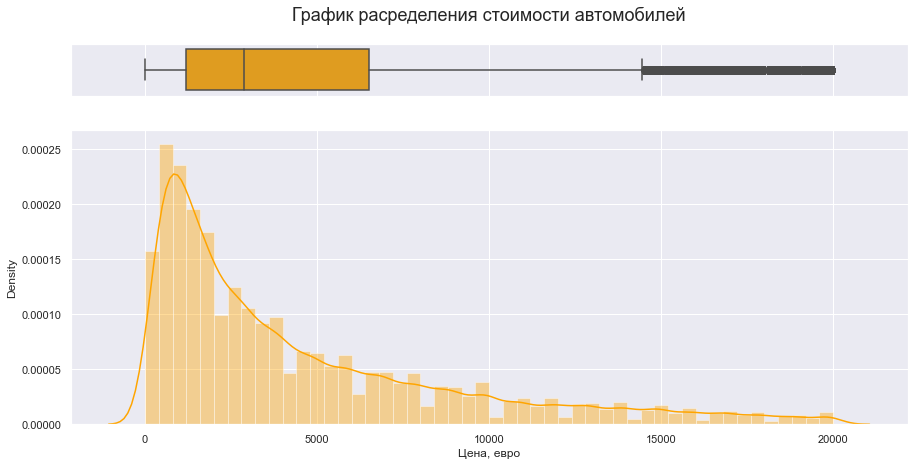

In [13]:
hist_boxplot(car_df.price, 'стоимости автомобилей', 'Цена, евро')

Автомобили стоимостью более 14000 евро можно считать редкими, но врятли их можно назвать выбросами. Проверим более приближенно автомобили стоимостью менее 200 евро

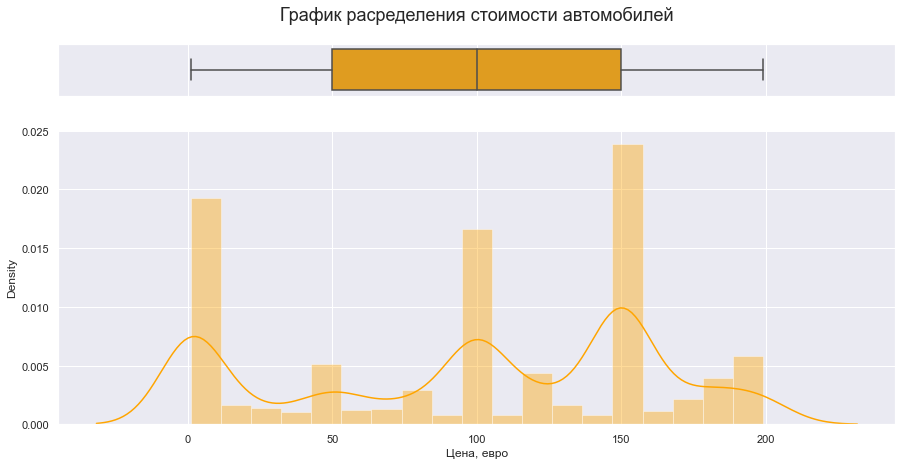

In [14]:
hist_boxplot(car_df.query('price < 200').price, 'стоимости автомобилей', 'Цена, евро')

Автомобили стоимостью менее 50 евро вызывают подозрение. Та же логика, что и с нулевыми значениями. Возможно стоит отказаться от таких строк. Выведем общее количество таких наблюдений

In [15]:
print(f'Количество автомобилей стоимостью менее 50 евро: {car_df.query("price < 50").shape[0]},',\
      f'что составляет {car_df.query("price < 50").shape[0] / car_df.shape[0]:.2%}')

Количество автомобилей стоимостью менее 50 евро: 1651, что составляет 0.48%


Мы не знаем за какой период (по году регистрации) наша выборка, но первый автомобиль с ДВС был построен в 1885 году, а выпущен в 1888 году. Но в наших данных имеются записи за 1000 и 9999 года. Выведем количество объектов с ложной информацией о годе регистрации автомобиля

In [16]:
fake_year = car_df.query('1888 > registration_year or registration_year > 2021')
display(fake_year.shape[0])

139

In [17]:
percent_nan_columns(fake_year, ' (ложный год регистрации)')

Количество пропусков по столбцам (ложный год регистрации), %:


date_crawled            0.0
price                   0.0
vehicle_type          100.0
registration_year       0.0
gearbox                80.6
power                   0.0
model                  38.1
kilometer               0.0
registration_month      0.0
fuel_type              74.1
brand                   0.0
not_repaired           84.9
date_created            0.0
number_of_pictures      0.0
postal_code             0.0
last_seen               0.0
dtype: float64

Всего 139 наблюдение с ложными данными по году регистрации автомобиля. Кроме того в этих наблюдениях имеется огромное количество пропусков. Считаю необходимым сразу избавится от этих строк.

In [18]:
car_df.drop(index=fake_year.index, inplace=True)
car_df.reset_index(drop=True, inplace=True)

Изучим распределение года регистрации автомобилей

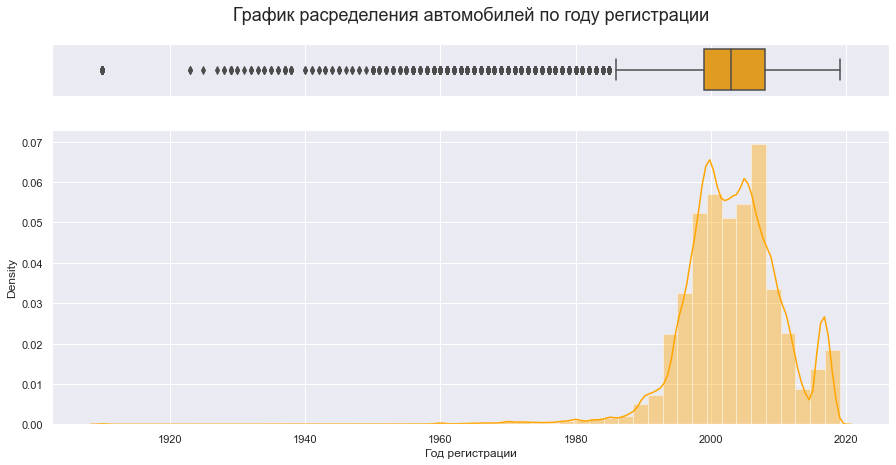

In [19]:
hist_boxplot(car_df.registration_year, 'автомобилей по году регистрации', 'Год регистрации')

Автомобили с регистрацией до 1980 года имеют небольшой объем в нашей выборке, а до 1960 года они совсем единичны. Возможно стоит обучать отдельную модель для предсказаний стоимости ретро-мобилей, а нам в данном проекте подобные строки будут только мешать, учитывая их малое количество(?).

В столбце "power" отсутствовали пропуски, но лошадиные силы принимают экстримально высокие значения, а так же имеются 0. Выведем количество нулевых значений в столбце

In [20]:
print(f'Количество строк с нулями по столбцу "power": {car_df.query("power == 0").shape[0]},',\
      f'что составляет {car_df.query("power == 0").shape[0]/ car_df.shape[0]:.2%}')

Количество строк с нулями по столбцу "power": 36259, что составляет 10.56%


Более 10% значений столбца "power" уже можно считать пропусками. Кроме того ранее мы заметили значение мощности доходящее до 20000 лошадиных сил, что явно можно считать некорректным значением. Максимальная стоимость автомобилей в нашей выборке 20000 евро, есть автомобили старых годов, можно предположить что в рамки такой стоимости попали старые но мощные автомобили, поэтому считаю что автомобили с мощностью более 600 лошадиных сил имеют неверное значение. Изучим график распределения признака без учета нулевых значений и не превышающие 600 л.с.

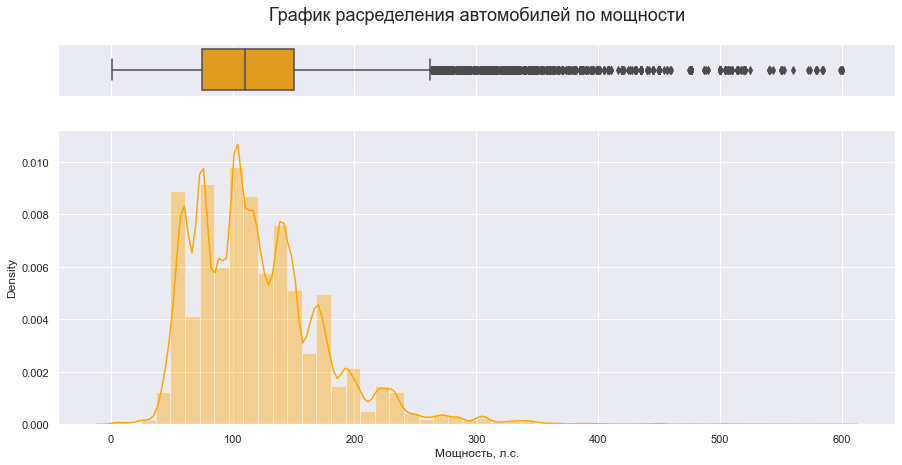

In [21]:
hist_boxplot(car_df.query('0 < power <= 600').power, 'автомобилей по мощности', 'Мощность, л.с.')

Даже при пороге в 600 л.с. имеется много выбросов. Изучим объекты с лошадиными силами от 600 до 1000 и от 400 до 600.

In [22]:
display(car_df.query('600 <= power < 1000').head(11))
display(car_df.query('400 < power < 600').head(11))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
3929,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46
6102,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31 00:00:00,0,44379,2016-04-01 03:41:52
6307,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN,2016-03-14 00:00:00,0,40721,2016-03-14 15:54:34
6435,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31 00:00:00,0,70327,2016-04-06 14:17:51
7807,2016-03-15 13:49:25,500,small,2002,manual,620,ypsilon,150000,12,petrol,lancia,NaN,2016-03-15 00:00:00,0,55566,2016-04-06 03:15:27
12350,2016-03-09 18:43:44,3500,convertible,2003,manual,952,ka,70000,5,petrol,ford,no,2016-03-09 00:00:00,0,26903,2016-03-12 04:16:07
12963,2016-03-31 12:38:14,18500,small,2002,auto,600,s_type,150000,12,NaN,jaguar,no,2016-03-31 00:00:00,0,13595,2016-04-06 04:46:34
20426,2016-03-16 16:46:57,3990,NaN,2017,manual,808,corsa,125000,10,NaN,opel,no,2016-03-16 00:00:00,0,45770,2016-03-19 14:18:02
22440,2016-03-19 22:51:21,400,NaN,2015,auto,610,other,5000,1,NaN,audi,NaN,2016-03-19 00:00:00,0,70178,2016-03-20 02:42:18
24389,2016-04-04 20:58:13,4300,NaN,2016,manual,696,fabia,150000,2,petrol,skoda,no,2016-04-04 00:00:00,0,4838,2016-04-06 23:44:26


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
2696,2016-03-16 00:37:16,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,2016-03-16 00:00:00,0,38448,2016-04-01 22:47:31
3181,2016-03-10 17:46:47,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-10 00:00:00,0,44319,2016-04-03 18:47:41
4527,2016-03-25 17:57:37,13900,sedan,2006,auto,476,e_klasse,150000,5,petrol,mercedes_benz,no,2016-03-25 00:00:00,0,52078,2016-04-06 23:17:21
5150,2016-03-27 17:57:40,10999,wagon,2006,auto,435,other,150000,12,petrol,audi,yes,2016-03-27 00:00:00,0,52249,2016-04-01 19:17:31
10046,2016-03-27 20:47:03,18900,wagon,2007,auto,420,3er,150000,12,petrol,bmw,no,2016-03-27 00:00:00,0,92358,2016-04-05 19:18:25
11264,2016-03-12 07:54:51,17900,wagon,2000,manual,500,other,150000,9,petrol,audi,NaN,2016-03-12 00:00:00,0,14612,2016-03-13 00:16:30
11735,2016-03-22 12:48:37,18900,sedan,2006,auto,450,other,150000,12,petrol,audi,no,2016-03-22 00:00:00,0,63872,2016-04-06 01:17:46
11894,2016-03-08 17:49:27,17200,wagon,2006,auto,435,a6,150000,11,petrol,audi,no,2016-03-08 00:00:00,0,38364,2016-04-07 08:44:33
12743,2016-03-09 14:37:23,16000,sedan,2006,auto,450,a8,150000,5,petrol,audi,no,2016-03-09 00:00:00,0,88353,2016-03-09 23:44:25
13342,2016-03-28 00:49:04,18300,suv,2007,auto,426,grand,100000,4,petrol,jeep,no,2016-03-27 00:00:00,0,70435,2016-04-06 09:15:19


Изучив выборочно объекты, пришел к выводу, что анкеты в данной выборке с мощностью двигателя более 598 л.с. в подавляющем большинстве можно считать некорректными. Заменим такие значения на NaN.

In [23]:
car_df['power'] = car_df['power'].replace(range(599, 20001), np.nan)

Кроме того изучив автомобили с низкой мощностью полагаю, что в данной выборке крайне маловероятно наличие автомобилей мощностью двигателя менее 26 лошадиных сил. Проверим наличие таких автомобилей

In [24]:
display(car_df.query('0 < power < 26').shape[0])

515

Считаю такие показатели мощности также некорректными. Заменим их, а так же нулевые значения на NaN

In [25]:
car_df['power'] = car_df['power'].replace(range(0, 26), np.nan)

В столбце "registration_month" вроде все в порядке, но месяц под номером 0 возможно дублирует месяц номер 12, что является лишним. Изучим распределения автомобилей по месяцу регистрации

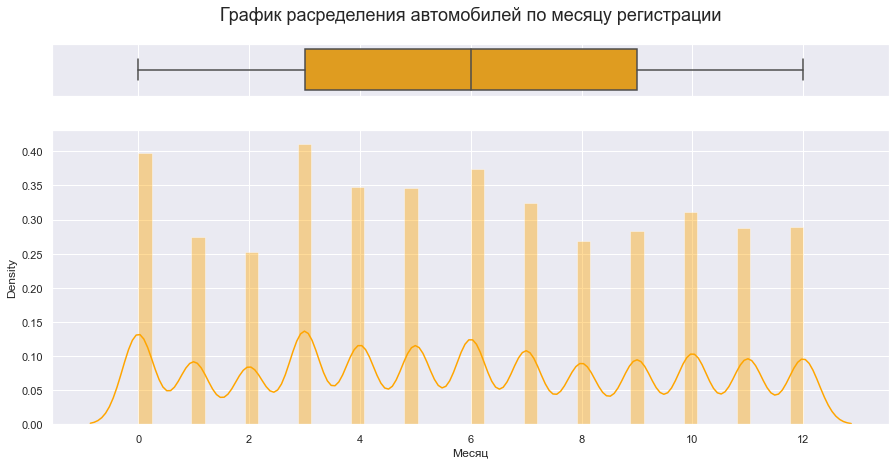

In [26]:
hist_boxplot(car_df.registration_month, 'автомобилей по месяцу регистрации', 'Месяц')

Как видно на графике, мы имеем примерно равномерное распределение количества автомобилей по месяцам, а значит мы не можем отнести значение 0 к какому либо другому. Удалять или заменять нули мы не будем, оставим их в своей категории.

Столбец "number_of_pictures" полностью состоит из 0, можем смело избавляться от него.

In [27]:
car_df.drop(['number_of_pictures'], axis=1, inplace=True)

Выведем уникальные значения столбца "vehicle_type". Для этого напишем функцию для вывода нужного нам графика распределения категориальных признаков

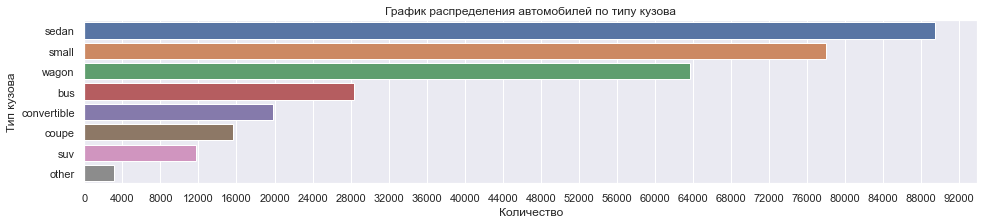

In [28]:
def my_barplot(sizeX, sizeY, df_col, bar_titl, bar_labl, xticks0, xticks_end, xticks_step):
    sns.set(style='darkgrid')
    plt.figure(figsize=(sizeX, sizeY))
    sns.barplot(y=df_col.value_counts().index, x=df_col.value_counts(), orient='h')
    plt.title(bar_titl)
    plt.xlabel('Количество')
    plt.ylabel(bar_labl)
    plt.xticks(np.arange(xticks0, xticks_end, xticks_step))
    plt.show()
    
    

my_barplot(16, 3, car_df.vehicle_type, 'График распределения автомобилей по типу кузова', 'Тип кузова', 0, 92001, 4000)

В столбце с информацией о типе кузова все корректно, за исключением пропусков. Нужно придумать метод их обработки.

Выведем уникальные значения столбца "gearbox"

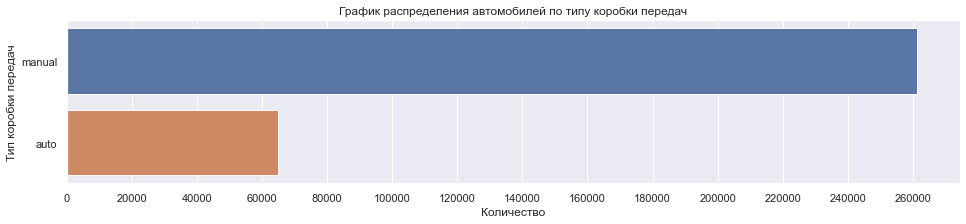

In [29]:
my_barplot(16, 3, car_df.gearbox, 'График распределения автомобилей по типу коробки передач',\
                                  'Тип коробки передач', 0, 265001, 20000)

В данном столбце все аналогично столбцу "vehicle_type". Большая часть атомобилей в выборке имеет ручную коробку передач

Изучим уникальные значения столбца "model"

In [30]:
display(car_df.model.value_counts())

golf                  28233
other                 23690
3er                   19175
polo                  12625
corsa                 12191
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64

Кроме 5.6% пропущенных значений в данном столбце также имеется 6.9% неизвестных моделей разных брендов с пометкой "other". Итого мы имеем 12.7% неизвестных моделей. Пока не понятно как предсказывать стоимость автомобиля не зная точно его модель. На данном этапе заменю "other" на NaN,  так как по сути это одно и тоже. Далее решим как будем обрабатывать пропуски.

In [31]:
car_df.model.replace('other', np.nan, inplace=True)

Изучим уникальные значения столбца "fuel_type"

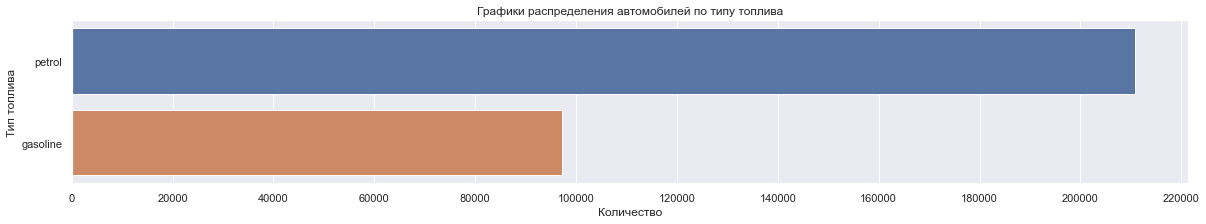

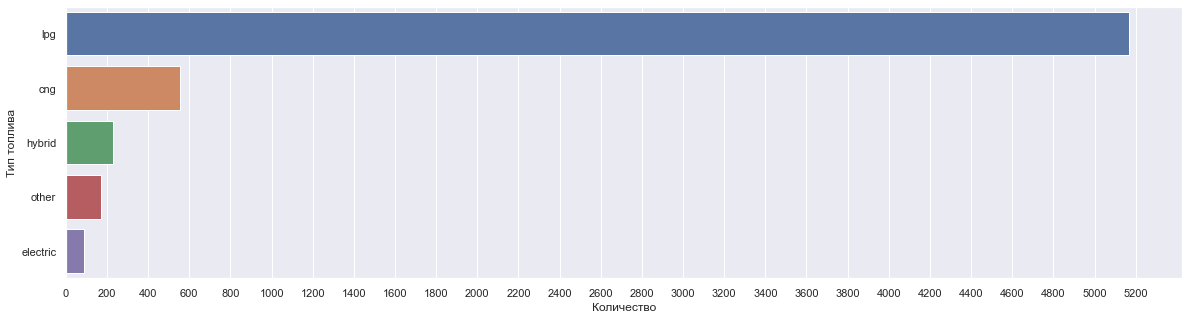

In [32]:
my_barplot(20, 3, car_df.query('fuel_type in ["petrol", "gasoline"]').fuel_type, \
           'Графики распределения автомобилей по типу топлива', 'Тип топлива', 0, 220001, 20000)
my_barplot(20, 5, car_df.query('fuel_type not in ["petrol", "gasoline"]').fuel_type, \
           '', 'Тип топлива', 0, 5201, 200)

В столбце типа топлива кроме 8.5% пропущенных значений на первый взгляд все в порядке. Имеется 169 автомобилей с видом топлива "other", но объединять их с пропусками не будем, так как кроме представленных выше видов топлива существуют и другие, менее популярные и известные. Petrol это бензин, gasoline это с небольшой долей вероятности дизель в Европе, поэтому объединять их не стоит. Lpg и cng это газы, но для них в автомобили устанавливается разное по стоимости газовое оборудование. Стоит отметить, что подавляющее большинство автомобилей в выборке имеют бензиновый и дизельный двигатель, немногие автомобиле имеют газовое оборудование, остальные совсем единичны в выборке.

Изучим уникальные значения столбца "brand"

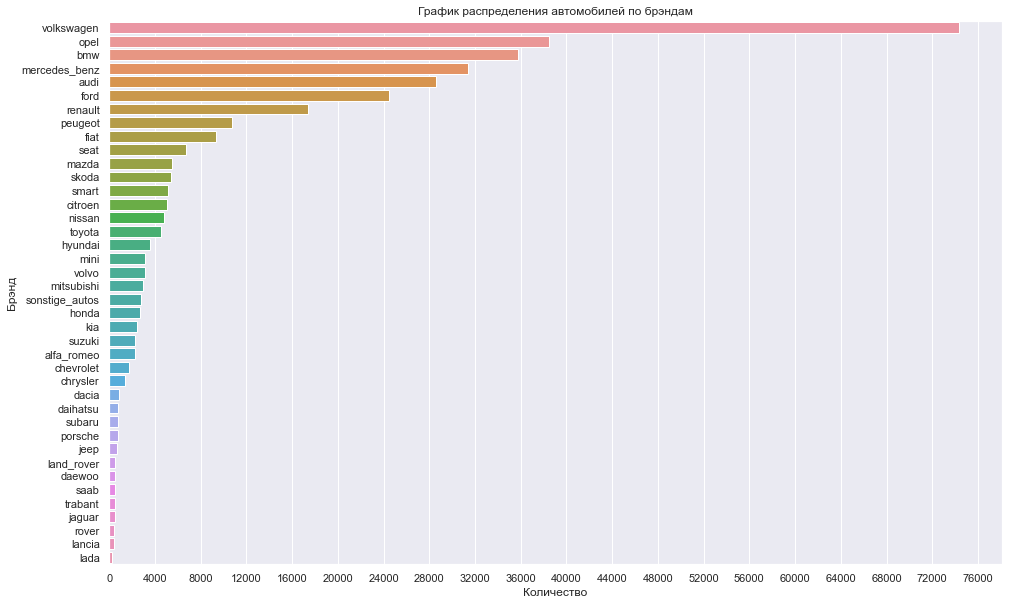

In [33]:
my_barplot(16, 10, car_df.brand, 'График распределения автомобилей по брэндам', 'Брэнд', 0, 76001, 4000)

Наибольшее количество автомобилей Германсокого производства. Если не учитывать Ford, то можно сказать что подавляющее большинство автомобилей европейского происхождения. Кроме того около 3000 автомобилей имеют пометку в брендах - "sontige_autos" (другие автомобили). Проверим наименования моделей таких брэндов, возможно по ним мы сможем восстановить эти пустоты.

In [34]:
display(car_df.query('brand == "sonstige_autos"').groupby('brand')['model'].count())

brand
sonstige_autos    0
Name: model, dtype: int64

К сожалению у таких автомобилей так же отсутствуют наименования моделей. Считаю что строки без наименования бренда и модели для нас будут в дальнейшем безполезны. Удалим такие объекты

In [35]:
car_df.drop(index=car_df.query('brand == "sonstige_autos"').index, inplace=True)
car_df.reset_index(drop=True, inplace=True)

Изучим график распределения автомобилей по признаку "not_repaired"

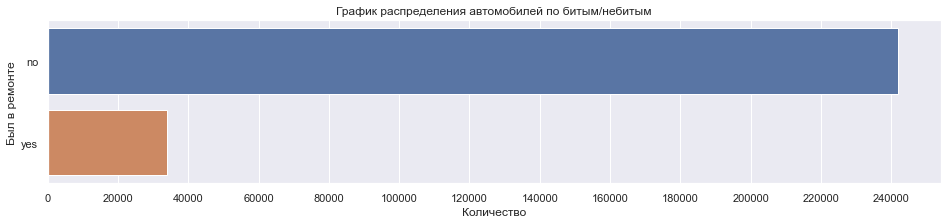

In [36]:
my_barplot(16, 3, car_df.not_repaired, 'График распределения автомобилей по битым/небитым', 'Был в ремонте', 0, 240001, 20000)

Большинство автомобилей в выборке никогда не были в ремонте. Кроме этого у нас имеется около 19% автомобилей по которым нет информации о наличии ремонта. Отнести к одной из категорий такие пропуски мы не можем, удалять такое количество наблюдений тоже не стоит, потеряем много данных. Вероятнее всего стоит отнести их к отдельной категории "неизвестно".

In [37]:
car_df.not_repaired.fillna('unknown', inplace=True)

У нас остался еще один неизученный признак - "postal_code". Считаю что почтовый индекс владельца анкеты никак нам не поможет в обучении модели, врятли он влияет на стоимость автомобиля, но будет заметно тормозить обучение при таком объеме данных. Лучше от него избавиться в дальнейшем.

Изучим корреляцию между признаками в числовом виде

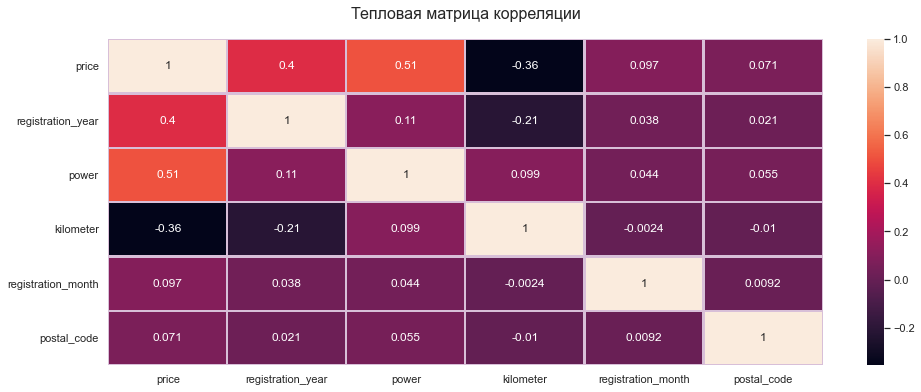

In [38]:
plt.figure(figsize=(16, 6))
my_heatmap = sns.heatmap(car_df.corr(), annot=True, linewidths=1.1, linecolor='thistle')
my_heatmap.set_yticklabels(my_heatmap.get_yticklabels(), rotation=0)
plt.title('Тепловая матрица корреляции', pad='20', fontsize=16)
plt.show()

Наблюдаем корреляцию не выше средней между целевым признаком и двумя признаками  - мощность двигателя и дата регистрации автомобиля, что вполне логично. С каждым десятилетием мощность двигателей автомобилей увеличивалась до недавнего времени.

Проверим наличие дубликатов

In [39]:
print(f'Количество полных дубликатов: {car_df.duplicated().sum()}')

Количество полных дубликатов: 4


Всего 4 дубликата. Удалим их

In [40]:
car_df.drop_duplicates(inplace=True)

Повторно выведем количество пропусков по каждому столбцу

In [41]:
percent_nan_columns(car_df, '')

Количество пропусков по столбцам, %:


date_crawled           0.0
price                  0.0
vehicle_type           9.7
registration_year      0.0
gearbox                4.9
power                 10.6
model                 11.3
kilometer              0.0
registration_month     0.0
fuel_type              8.4
brand                  0.0
not_repaired           0.0
date_created           0.0
postal_code            0.0
last_seen              0.0
dtype: float64

**ВЫВОД:**

Во время изучения данных и первичной предобработки были сделаны следующие выводы и шаги:
1. Признаки "date_crawled", "date_created", "number_of_pictures", "postal_code" и "last_seen" не несут никакой полезной информации и не имеют отношение к предсказанию стоимости автомобиля. Их необходимо удалить. Признак "number_of_pictures" уже удален из данных.
2. Целевой признак "price":
    - 3% автомобилей имели 0 по стоимости. Пришлось удалить такие объекты
    - 0.48% автомобилей в данных стоимостью менее 50 евро и в основном около 1 евро. Считаю такие объявления некорректными, стоит удалить подобные строки
    - В основном в выборке автомобили стоимостью до 10000 евро, максимальная стоимость - 20000 евро.
    - Необходимо для сокращения использования памяти изменить тип данных столбца на uint16
3. Признак "vehicle_type":
    - В данном стобце за исключением 9.8% пропусков все корректно. Пропусков слишком много для того чтобы их удалять. Стоит попробовать заполнить пропуски в зависимости от модели автомобиля как наиболее часто встречаемые, в большинстве случаев по моему мнению мы угадаем тип кузова, но для этого необходимо сначало обработать пропуски у моделей.
    - Необходимо изменить тип данных на категориальный.
4. Признак "registration_year":
    - По данному столбцу было обнаружено 139 автомобилей, не попадающих в адекватный годовой период - от 1988 года до 2021. Кроме того они же имели большое количество пропусков по различным признакам. Данные объекты были удалены из выборки.
    - Необходимо изменить тип данных на категориальный.
5. Признак "gearbox":
    - Признак имеет разделение всего на 2 категории - ручная коробка передач и автоматическая.
    - Имеется 4.9% пропусков. Предлагаю способ заполнения аналогичный заполнению пропусков в признаке "vehicle_type"
    - Необходимо изменить тип данных на категориальный.
6. Признак "power":
    - Было обнаружено 10.6% нулевых значений. Временно они помечены как пропуски
    - 515 автомобилей в выборке имели крайне подозрительный показатель мощности - ниже 26 лошадиных сил. Заменили такие значения на NaN.
    - Ряд автомобилей имел слишком высокий показатель мощности достигавший 20000 лошадиных сил, учитывая что в нашей выборке представлены автомобили не дороже 20000 евро. После анализа пришли к выводу об установлении порога адекватного значения мощности в 598 лошадиных сил, у автомобилей превышающих этот порог показание мощности было заменено на NaN.
    - В итоге имеем по данному столбцу 10.5% пропусков. Предлагаю заполнить их медианным значением в зависимости от модели и года регистрации автомобиля.
7. Признак "model":
    - Было обнаружено 5.6% пропущенных значений
    - Данный признак - категориальный, имеет 249 уникальных наименований моделей.
    - Одна категория имела обозначение "other", что смело можно приравнивать к пропускам. Заменили значения "other" на NaN.
    - В итоге по данному столбцу имеем 11.3% пропусков
    - Необходимо изменить тип данных на категориальный.
    - Считаю, что восстановление пропусков в данном столбце будет сильной натяжкой. Я попробовал 2 способа заполнения (не стал включать их в проект):
        - Наиболее частые модели при группировке по брэндам при помощи функций mode() и transform(). Такой способ работает быстро , восстанавливает все пропуски, но при детальной проверке ряда автомобилей марка не всегда соответствует действительности. Например в одном из пропусков брэнду audi была сопоставлена марка a4, хотя по всем признакам более подходящая марка должна быть а6.
        - Наиболее частые модели при группировке по брэндам, году регистрации и мощности автомобиля при помощи собственной функции. Такой способ как мне показалось восстанавливает пропуски максимально приближенно к реальности. Но есть две причины, по которым я отказался от него. Первая - восстанавливается только половина пропусков. Вторая - время восстановления около 7 минут на моей машине.
    - В связи с этим считаю необходимым удалить все строки с пропусками в столбце "model".
8. Признак "kilometer":
    - В данном столбце все корректно. Необходимо заменить тип данных на uint32.
9. Признак "registration_month":
    - Считаю, что данный столбец никак не влияет, даже косвенно, на ценообразование при оценке автомобилей. Стоит удалить данный признак из выборки, но прежде изучить график изменения цены в зависимости от месяца за определенный период, например с 2010 по 2020 год.
    - В случае использования признака для обучения модели необходимо изменить тип данных на категориальный
10. Признак "fuel_type":
    - Было обнаружено 8.4% пропусков.
    - Предлагаю способ заполнения аналогичный заполнению пропусков в признаке "vehicle_type".
    - Необходимо изменить тип данных на категориальный.
11. Признак "brand":
    - В данном столбце имеется 39 уникальных брэндов.
    - Было обнаружено около 3000 автомобилей с пометкой "sontige_autos" (другие автомобили). По ним так же отсутствовала информация по наименованию моделей. Такие строки были удалены.
    - Пропуски отсутствуют.
    - Считаю данный признак лишней и безсмысленной нагрузкой для обучения модели, так как фактически наименование модели само по себе подразумевает наименование брэнда, ведь наименования моделей у каждого брэнда уникальны. Стоит удалить из выборки данный признак.
12. Признак "not_repaired":
    - В данном столбце отсутствуют пропуски.
    - По 19% автомобилей нет информации были ли они когда либо в ремонте.  Отнести к одной из категорий такие пропуски мы не можем. Отнести их к отдельной категории "неизвестно".
    - Необходимо изменить тип данных на категориальный.

### Предобработка данных

На основе выводов предыдущего подраздела, в данном подразделе для каждого признака совершим определенные действия.

#### Признак "registration_month"

Изучим график изменения средней цены в зависимости от месяца за период с 2010 по 2021 год.

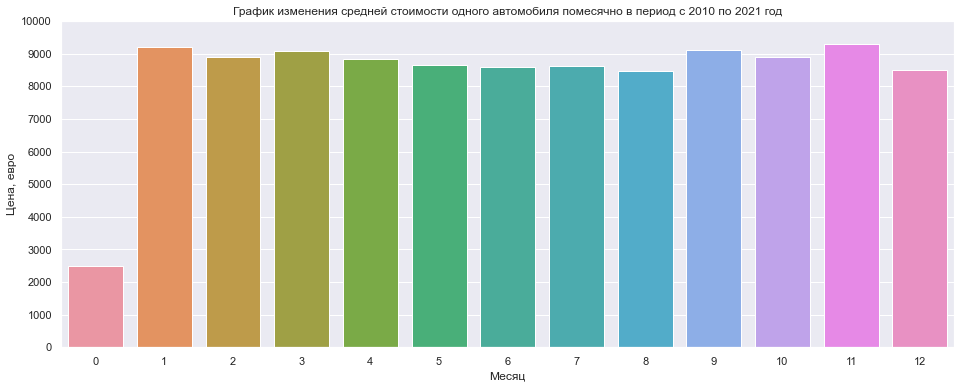

In [42]:
decade = car_df.query('registration_year > 2009').pivot_table(index = 'registration_month',\
                                                              values = 'price',\
                                                              aggfunc= 'mean')
plt.figure(figsize=(16, 6))
sns.barplot(x=decade.index, y=decade.price)
plt.title('График изменения средней стоимости одного автомобиля помесячно в период с 2010 по 2021 год')
plt.xlabel('Месяц')
plt.ylabel('Цена, евро')
plt.yticks(np.arange(0, 10001, 1000))
plt.show()

Как видим стоимость одного автомобиля в среднем ежемесячно находится примерно на одном уровне. Но неизвестный месяц под номером "0" может негативно влиять на предсказания нашей модели. Считаю необходимым удалить данный признак из выборки. Кроме того ранее мы решили избавиться от части ненужных для обучения модели признаков. Сделаем это сейчас

In [43]:
car_df.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen', 'registration_month', 'brand'], axis=1, inplace=True)

#### Целевой признак "price"

Удалим из выборки автомобили стоимостью менее 50 евро

In [44]:
car_df =  car_df.query('price >= 50')

Изменим тип данных на uint16

In [45]:
car_df.price = car_df.price.astype('uint16')

#### Признак "kilometer"

Изменим тип данных на uint32

In [46]:
car_df.kilometer = car_df.kilometer.astype('uint32')

#### Признак "model"

Проверим, сколько мы потеряем данных при удалении пропусков по данному признаку

In [47]:
print('Количество потерянных данных при удалении строк с пропусками в наименовании модели:', 
      round(car_df[car_df.model.isna()].shape[0] * 100 / car_df.shape[0], 2), '%')

Количество потерянных данных при удалении строк с пропусками в наименовании модели: 11.19 %


Процент приличный но не большой. Лучше обучить модель на реальных данных, чем на некорректных, кроме того у нас достаточно большой объем наблюдений в распоряжении.

In [48]:
car_df.dropna(subset=['model'], inplace=True)

#### Признак "vehicle_type"

In [49]:
car_df.vehicle_type.fillna(car_df.groupby('model').vehicle_type.transform(lambda x: x.mode()[0]), inplace=True)

#### Признак "gearbox"

In [50]:
car_df.gearbox.fillna(car_df.groupby('model').gearbox.transform(lambda x: x.mode()[0]), inplace=True)

#### Признак "fuel_type"

In [51]:
car_df.fuel_type.fillna(car_df.groupby('model').fuel_type.transform(lambda x: x.mode()[0]), inplace=True)

#### Признак "power"

Заполним пропуски в данном признаке медианой по сгруппированным данным в зависимости от модели и года регистрации автомобиля

In [52]:
car_df.power.fillna(car_df.groupby(['model', 'registration_year']).power.transform('median'), inplace=True)

Проверим, остались ли у нас пропуски

In [53]:
percent_nan_columns(car_df, '')

Количество пропусков по столбцам, %:


price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.1
model                0.0
kilometer            0.0
fuel_type            0.0
not_repaired         0.0
dtype: float64

0.1% мизерная доля. Заполним их медианой по сгруппированным данным в зависимости от модели автомобиля и снова проверим

In [54]:
car_df.power.fillna(car_df.groupby('model').power.transform('median'), inplace=True)
print(f'Количество пропусков по столбцу model: {car_df[car_df.power.isna()].shape[0]}')

Количество пропусков по столбцу model: 1


Удалим его

In [55]:
car_df.dropna(inplace=True)
car_df.reset_index(drop=True, inplace=True)

Изменим тип данных на uint16

In [56]:
car_df.power = car_df.power.astype('uint16')

Проверим общее количество потерянных данных после обработки пропусков и исключения аномалий

In [57]:
print(f'Общая потеря данных составила: {1 - (car_df.shape[0] / LEN_DF):.2%}')

Общая потеря данных составила: 15.02%


#### Изменение типа данных у категориальных признаков

In [58]:
category_list = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'not_repaired']
car_df[category_list] = car_df[category_list].astype('category')

Выведем общую информацию по таблице

In [59]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301151 entries, 0 to 301150
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              301151 non-null  uint16  
 1   vehicle_type       301151 non-null  category
 2   registration_year  301151 non-null  category
 3   gearbox            301151 non-null  category
 4   power              301151 non-null  uint16  
 5   model              301151 non-null  category
 6   kilometer          301151 non-null  uint32  
 7   fuel_type          301151 non-null  category
 8   not_repaired       301151 non-null  category
dtypes: category(6), uint16(2), uint32(1)
memory usage: 4.3 MB


Все корректно

## Обучение моделей

Для начала разделим данные на признаки и целевой признак

In [60]:
X = car_df.drop('price', axis=1)
y = car_df.price

Разделим данные на обучающую и тестовую выборки в соотношении 3:1

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=99)

**Подготовим пустую таблицу в которую будем добавлять результаты кросс-валидации различных моделей (Был проведен подбор оптимальных гиперпараметров для моделей, но не включен в проект ввиду крайне длительного по времени данного процесса. Далее мы будем уже по подобраным гиперпараметрам обучать модели).**

In [62]:
all_result = pd.DataFrame(columns=['Модель', 'Оптимальные параметры', 'RMSE кросс-валидация',\
                                   'Время обучения, сек.', 'RMSE тест', 'Время предсказания, сек.'])

Подготовим две функции:
1. Для вывода метрики RMSE на тестовой выборке
2. Pipeline:
    - На вход получит данные, определенную модель, гиперпараметры модели, признаки и целевой признак для кросс-валидации, наименование модели и таблицу для добавления результатов
    - Категориальные признаки будут закодированы при помощи OneHotEncoder, а числовые стандартизированы при помощи StandardScaler в процессе кроссвалидации
    - На выходе сохранит в переменную обученную модель с оптимальными гиперпараметрами, добавит результаты кросс-валидации в таблицу, выведет результаты по текущей модели

In [63]:
def my_rmse(true_y, pred_y):
    return round(mean_squared_error(true_y, pred_y) ** 0.5, 2)



def my_pipe(pipe_df, pipe_regressor, regressor_param, X_tr, y_tr, model_name, results):
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    numeric_features = pipe_df.select_dtypes(include=['uint16', 'uint32']).drop(['price'], axis=1).columns
    categorical_features = pipe_df.select_dtypes(include=['category']).columns
    
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),\
                                                   ('cat', categorical_transformer, categorical_features)])
    
    ss_ohe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', pipe_regressor)])
    
    CV = GridSearchCV(ss_ohe, regressor_param, cv = 5,\
                      n_jobs = -1, verbose = 0, pre_dispatch='2 * n_jobs',\
                      scoring = 'neg_mean_squared_error')
    
    time_start_fit = timeit.default_timer()
    CV.fit(X_tr, y_tr)
    time_fit = timeit.default_timer() - time_start_fit
    
    result = pd.DataFrame(data=[[model_name, CV.best_params_, round((-CV.best_score_) ** 0.5, 2),\
                                 round(time_fit, 2), None, None]],\
                          columns=['Модель', 'Оптимальные параметры', 'RMSE кросс-валидация',\
                                   'Время обучения, сек.', 'RMSE тест', 'Время предсказания, сек.'])
    display(result)
    return results.append(result, ignore_index=True), CV.best_estimator_

Проверим работу функции и выведем результат базовой модели DummyRegressor, который будем в дальнейшем сравнивать с результатами остальных моделей

In [64]:
all_result, dummy = my_pipe(car_df, DummyRegressor(),\
                            {'regressor__strategy': ['mean', 'median']},\
                            X_train, y_train, 'DummyRegressor', all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,DummyRegressor,{'regressor__strategy': 'mean'},4521.28,5.96,None,None


Далее поочередно обучим Дерево решений, три линейных модели, а так-же две модели с использованием градиентного бустинга.

In [65]:
all_result, lin_reg = my_pipe(car_df, LinearRegression(), {},\
                              X_train, y_train, 'LinearRegression', all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,LinearRegression,{},2051.88,18.38,None,None


In [66]:
all_result, tree = my_pipe(car_df, DecisionTreeRegressor(random_state=99),\
                           {'regressor__max_depth': [42], 'regressor__max_features': [39]},\
                           X_train, y_train, 'DecisionTreeRegressor', all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,DecisionTreeRegressor,"{'regressor__max_depth': 42, 'regressor__max_features': 39}",1954.73,33.36,None,None


In [67]:
all_result, elastic = my_pipe(car_df, ElasticNet(random_state=99),\
                              {'regressor__alpha': [0.01], 'regressor__l1_ratio': [0.9]},\
                              X_train, y_train, 'ElasticNet', all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9}",2097.19,261.58,None,None


In [68]:
all_result, lasso = my_pipe(car_df, Lasso(random_state=99), {},\
                            X_train, y_train, 'Lasso', all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,Lasso,{},2092.85,124.94,None,None


In [69]:
all_result, cbr = my_pipe(car_df, CatBoostRegressor(random_state=99, verbose=0),\
                          {'regressor__iterations': [1200], 'regressor__depth': [6], 'regressor__learning_rate': [0.5],\
                           'regressor__loss_function': ['RMSE']},\
                          X_train, y_train, 'CatBoostRegressor', all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,CatBoostRegressor,"{'regressor__depth': 6, 'regressor__iterations': 1200, 'regressor__learning_rate': 0.5, 'regressor__loss_function': 'RMSE'}",1541.96,138.18,None,None


In [70]:
all_result, lgbmr = my_pipe(car_df, LGBMRegressor(random_state=99),\
                            {'regressor__max_depth': [17], 'regressor__n_estimators': [1400], 'regressor__num_leaves': [71]},\
                            X_train, y_train, 'LGBMRegressor', all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,LGBMRegressor,"{'regressor__max_depth': 17, 'regressor__n_estimators': 1400, 'regressor__num_leaves': 71}",1524.86,82.77,None,None


Изучим полученные результаты

In [71]:
display(all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,DummyRegressor,{'regressor__strategy': 'mean'},4521.28,5.96,None,None
1,LinearRegression,{},2051.88,18.38,None,None
2,DecisionTreeRegressor,"{'regressor__max_depth': 42, 'regressor__max_features': 39}",1954.73,33.36,None,None
3,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9}",2097.19,261.58,None,None
4,Lasso,{},2092.85,124.94,None,None
5,CatBoostRegressor,"{'regressor__depth': 6, 'regressor__iterations': 1200, 'regressor__learning_rate': 0.5, 'regressor__loss_function': 'RMSE'}",1541.96,138.18,None,None
6,LGBMRegressor,"{'regressor__max_depth': 17, 'regressor__n_estimators': 1400, 'regressor__num_leaves': 71}",1524.86,82.77,None,None


Все модели прошли проверку на вменяемость в сравнении моделью DummyRegressor, которая предсказывала всегда среднюю стоимость автомобиля. Хуже всех с задачей справились линейные модели, их RMSE не опустился ниже 2000, а скорость обучения хуже в сревнении с Деревом решения. По показателю метрики качества чуть лучше с задачей справилась модель Дерево решений, RMSE у нее 1954, кроме того скорость обучения у данной модели быстрее чем у остальных в разы. Лучшими же по показателю RMSE по результатам кросс-валидации оказались модели с использованием градиентного бустинга. Они показали премерно одинаковый результат - не менее 1520, но скорость обучения у модели LGBMRegressor в 1.5 раза лучше чем у CatBoostRegressor. Посмотрим как поведут себя модели на тестовой выборке.

## Тестирование моделей

Сохраним в переменную список всех обученных моделей

In [72]:
models = [dummy, lin_reg, tree, elastic, lasso, cbr, lgbmr]

Через цикл протестируем все модели и добавим результаты в таблицу

In [73]:
for i in range(len(models)):
    time_start_pred = timeit.default_timer()
    pred = models[i].predict(X_test)
    all_result.iloc[i, 5] = round(timeit.default_timer() - time_start_pred, 2)
    all_result.iloc[i, 4] = (my_rmse(y_test, pred))

## Вывод и анализ моделей

<p style='text-align: justify;'> Перед обучением моделей мы загрузили и изучили данные, а так-же провели предобработку данных. На входе мы имели 354369 объявления о продаже автомобилей и 16 признаков, один из которых, цена автомобиля в евро, целевой. В ходе предобработки от части признаков мы избавились, так как они не имели никакого отношения к ценообразованию автомобиля, а так же от признака "брэнд", так как по сути информацию о брэнде несет в себе наименование модели. В части данных были пропуски, а именно: "vehicle_type" - 10.6%, "gearbox" - 5.6%, "model" - 5.6%, "fuel_type" - 9.3%, "not_repaired" - 20.1%. К сожалению восстановить пропуски в наименовании модели не удалось, пришлось удалить такие строки. Так же было обнаружено наименование модели со значением "other", такие объявления были удалены. Пропуски в типе кузова, коробке передач и типе топлива заполнили значениями в зависимости от модели автомобиля как наиболее часто встречаемые. Пропуски в признаке "not_repaired" решили заменить на "неизветно". По столбцу с годом регистрации было обнаружено 139 автомобилей, не попадающих в адекватный годовой период - от 1988 года до 2021. Кроме того они же имели большое количество пропусков по различным признакам. Данные объекты были удалены из выборки. По признаку мощность автомобиля было обнаружено 10.6% нулевых значений, 515 автомобилей в выборке имели крайне подозрительный показатель мощности - ниже 26 лошадиных сил, а так же ряд автомобилей имел слишком высокий показатель мощности достигавший 20000 лошадиных сил (после детального анализа пришли к выводу об установлении порога адекватного значения мощности в 598 лошадиных сил). В итоге было принято решение замены всех подобных значений мощности на медианное в зависимости от модели и года регистрации автомобиля. По целевому признаку были выявлены и удалены аномалии. 3% автомобилей имели 0 по стоимости, а 0.48% автомобилей в данных стоимостью менее 50 евро и в основном около 1 евро. По итогам предобработки данных мы потеряли 15% наблюдений и отказались от дальнейшего использования 7 признаков.

Мы подобрали гиперпараметры и обучили 6 различных моделей. Все они прошли проверку на вменяемость в сравнении с моделью DummyRegressor, которая предсказывала всегда среднюю стоимость автомобиля. В итоге все модели были протестированы. Проанализируем результат тестирования. </p>

In [74]:
display(all_result)

,Модель,Оптимальные параметры,RMSE кросс-валидация,"Время обучения, сек.",RMSE тест,"Время предсказания, сек."
0,DummyRegressor,{'regressor__strategy': 'mean'},4521.28,5.96,4506.14,0.16
1,LinearRegression,{},2051.88,18.38,2042.81,0.14
2,DecisionTreeRegressor,"{'regressor__max_depth': 42, 'regressor__max_features': 39}",1954.73,33.36,1900.4,0.16
3,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9}",2097.19,261.58,2085.49,0.14
4,Lasso,{},2092.85,124.94,2079.52,0.11
5,CatBoostRegressor,"{'regressor__depth': 6, 'regressor__iterations': 1200, 'regressor__learning_rate': 0.5, 'regressor__loss_function': 'RMSE'}",1541.96,138.18,1512.38,0.23
6,LGBMRegressor,"{'regressor__max_depth': 17, 'regressor__n_estimators': 1400, 'regressor__num_leaves': 71}",1524.86,82.77,1494.86,4.18


У линейных моделей единственственное преимущество перед остальными моделями (кроме дерева решений) - у них очень быстрая скорость предсказания, но качество так же как и на обучающей выборке хуже остальных. Дерево решений - середнячок по качеству предсказаний и лучшая модель по скорости предсказания. Значительно лучше остальных по качеству предсказания справились с задачей модели  с использованием градиентного бустинга. Модели CatBoostRegressor и LGBMRegressor показали примероно одинковое качество по значению метрики RMSE - при определении стоимости автомобиля они в среденем ошибаются на 1500 евро. Но стоит отметить что обе модели не исчерпали свой потенциал, так как большая часть гиперпараметров не была задействована в переборе, а значит метрику качества можно улучшать.